# Imports

In [1]:
import monai
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference, SimpleInferer
from monai.data import CacheDataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import glob
import numpy as np
from monai.utils import first, set_determinism
from monai.data import Dataset, ArrayDataset, DataLoader, load_decathlon_datalist
from monai.transforms import (Transform,AsDiscrete,Activations, Activationsd, Compose, LoadImaged,
                              Transposed, ScaleIntensityd, RandAxisFlipd, RandRotated, RandAxisFlipd,
                              RandBiasFieldd, ScaleIntensityRangePercentilesd, RandAdjustContrastd,
                              RandHistogramShiftd, DivisiblePadd, Orientationd, RandGibbsNoised, Spacingd,
                              RandRicianNoised, AsChannelLastd, RandSpatialCropd,ToNumpyd,EnsureChannelFirstd,
                              RandSpatialCropSamplesd, RandCropByPosNegLabeld)
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, BasicUNet
from monai.data.utils import pad_list_data_collate
import pandas as pd
import random as rd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
import nibabel as nib
from torch.optim.lr_scheduler import StepLR
import pytorch_lightning
from monai.utils import set_determinism

# DataLoader

In [19]:

transforms = Compose(
    [
        
        LoadImaged(keys=["img", "mask"],image_only=True),
        DivisiblePadd(["img","mask"], 16),
        EnsureChannelFirstd(keys=["img","mask"]),
        ScaleIntensityd(keys=["img"],
            minv=0.0,
            maxv=1.0),
        RandRotated(keys=["img", "mask"],
            range_x=np.pi / 12,
            prob=0.5,
            keep_size=True,
            mode="nearest")
        
    ]
)



def load_data(batch, root_dir):
   
    data = pd.read_csv(os.path.join(root_dir,'segmentation.csv'))
    imgs_list = list(data['participant_id'])
    masks_list = list(data['masks'])
    length = len(imgs_list)
    print(f'Total images: {length}') 
    test = int(0.90*length)
    first = int(0.75*length)

    imgs_list_train = imgs_list[0:first]
    imgs_list_val = imgs_list[first:test]
    imgs_list_test = imgs_list[test:]
    masks_list_train = masks_list[0:first]
    masks_list_val = masks_list[first:test]
    masks_list_test = masks_list[test:]

    print('train set', len(imgs_list_train), len(masks_list_train))
    print('val set', len(imgs_list_val), len(masks_list_val))
    print('test set', len(imgs_list_test), len(masks_list_test))

    filenames_train = [{"img": x, "mask": y} for (x,y) in zip(imgs_list_train, masks_list_train)]


    ds_train = monai.data.Dataset(filenames_train, transforms)
    train_loader = DataLoader(ds_train, batch_size=batch, shuffle = True, num_workers=2, pin_memory=True, collate_fn=pad_list_data_collate)

    filenames_val = [{"img": x, "mask": y} for (x, y) in zip(imgs_list_val, masks_list_val)]

    ds_val = monai.data.Dataset(filenames_val, transforms)
    val_loader = DataLoader(ds_val, batch_size=batch, shuffle=True, num_workers=1, pin_memory=True, collate_fn=pad_list_data_collate)

    filenames_test = [{"img": x, "mask":y} for (x,y) in zip(imgs_list_test,masks_list_test)]
    ds_test = monai.data.Dataset(filenames_test,transforms)
    test_loader = DataLoader(ds_test, batch_size = batch, shuffle=True,num_workers=1, pin_memory=True,collate_fn=pad_list_data_collate)
    
    return ds_train, train_loader, ds_val, val_loader, ds_test,test_loader

# Testing with dataset:

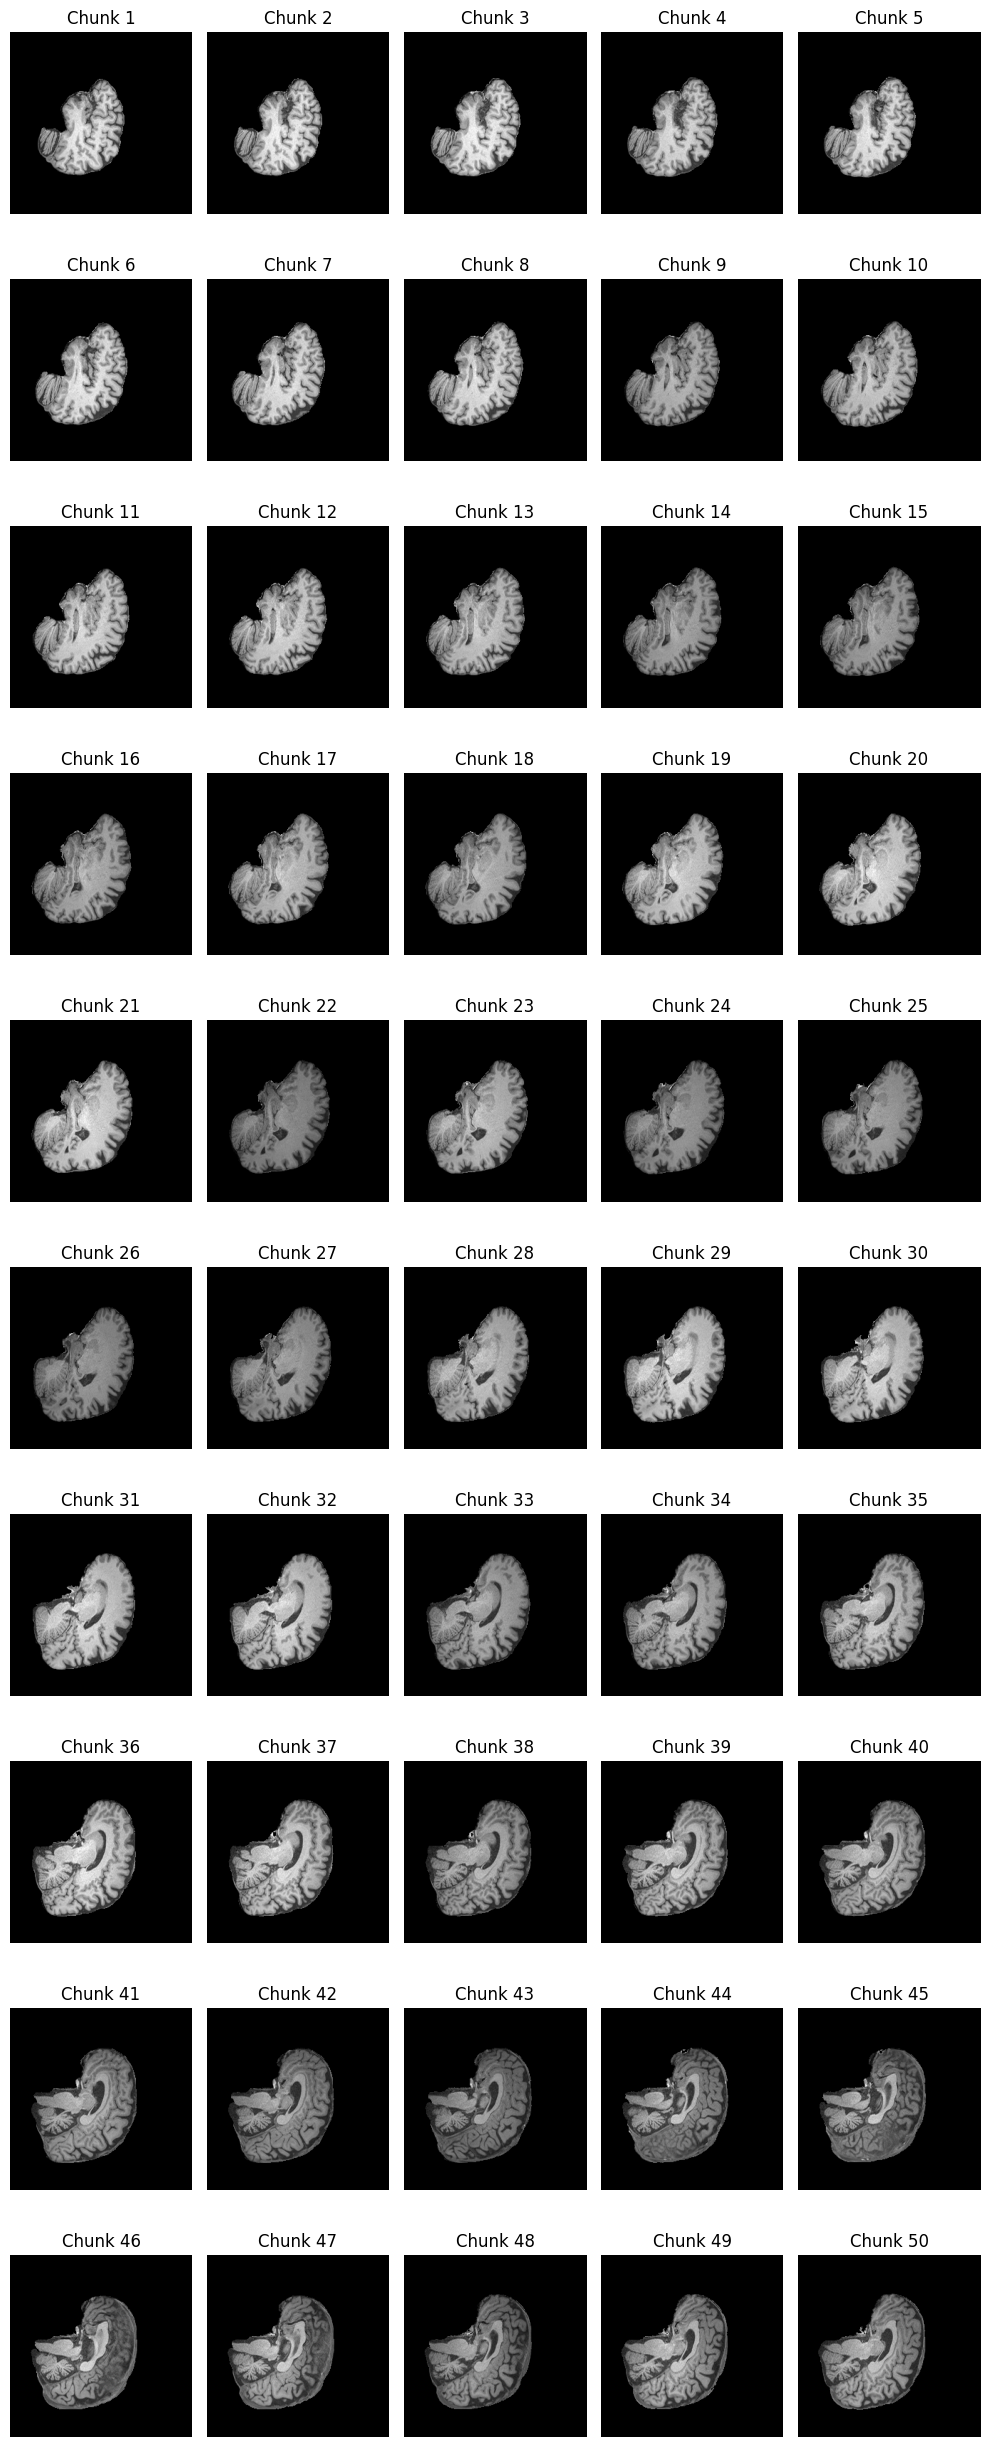

In [8]:
# Lets plot some pieces of 3D image from data set along with masks
img =  (ds_train[420]['img'])
image_array = np.squeeze(img.numpy())
num_chunks = 50
num_slices_per_chunk = image_array.shape[-1] // num_chunks

plt.figure(figsize=(10, 25))
for i in range(num_chunks):
    start_slice = i * num_slices_per_chunk
    end_slice = (i + 1) * num_slices_per_chunk
    plt.subplot(10, 5, i + 1) 
    plt.imshow(image_array[:, :, i+50], cmap='gray') 
    plt.title(f"Chunk {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


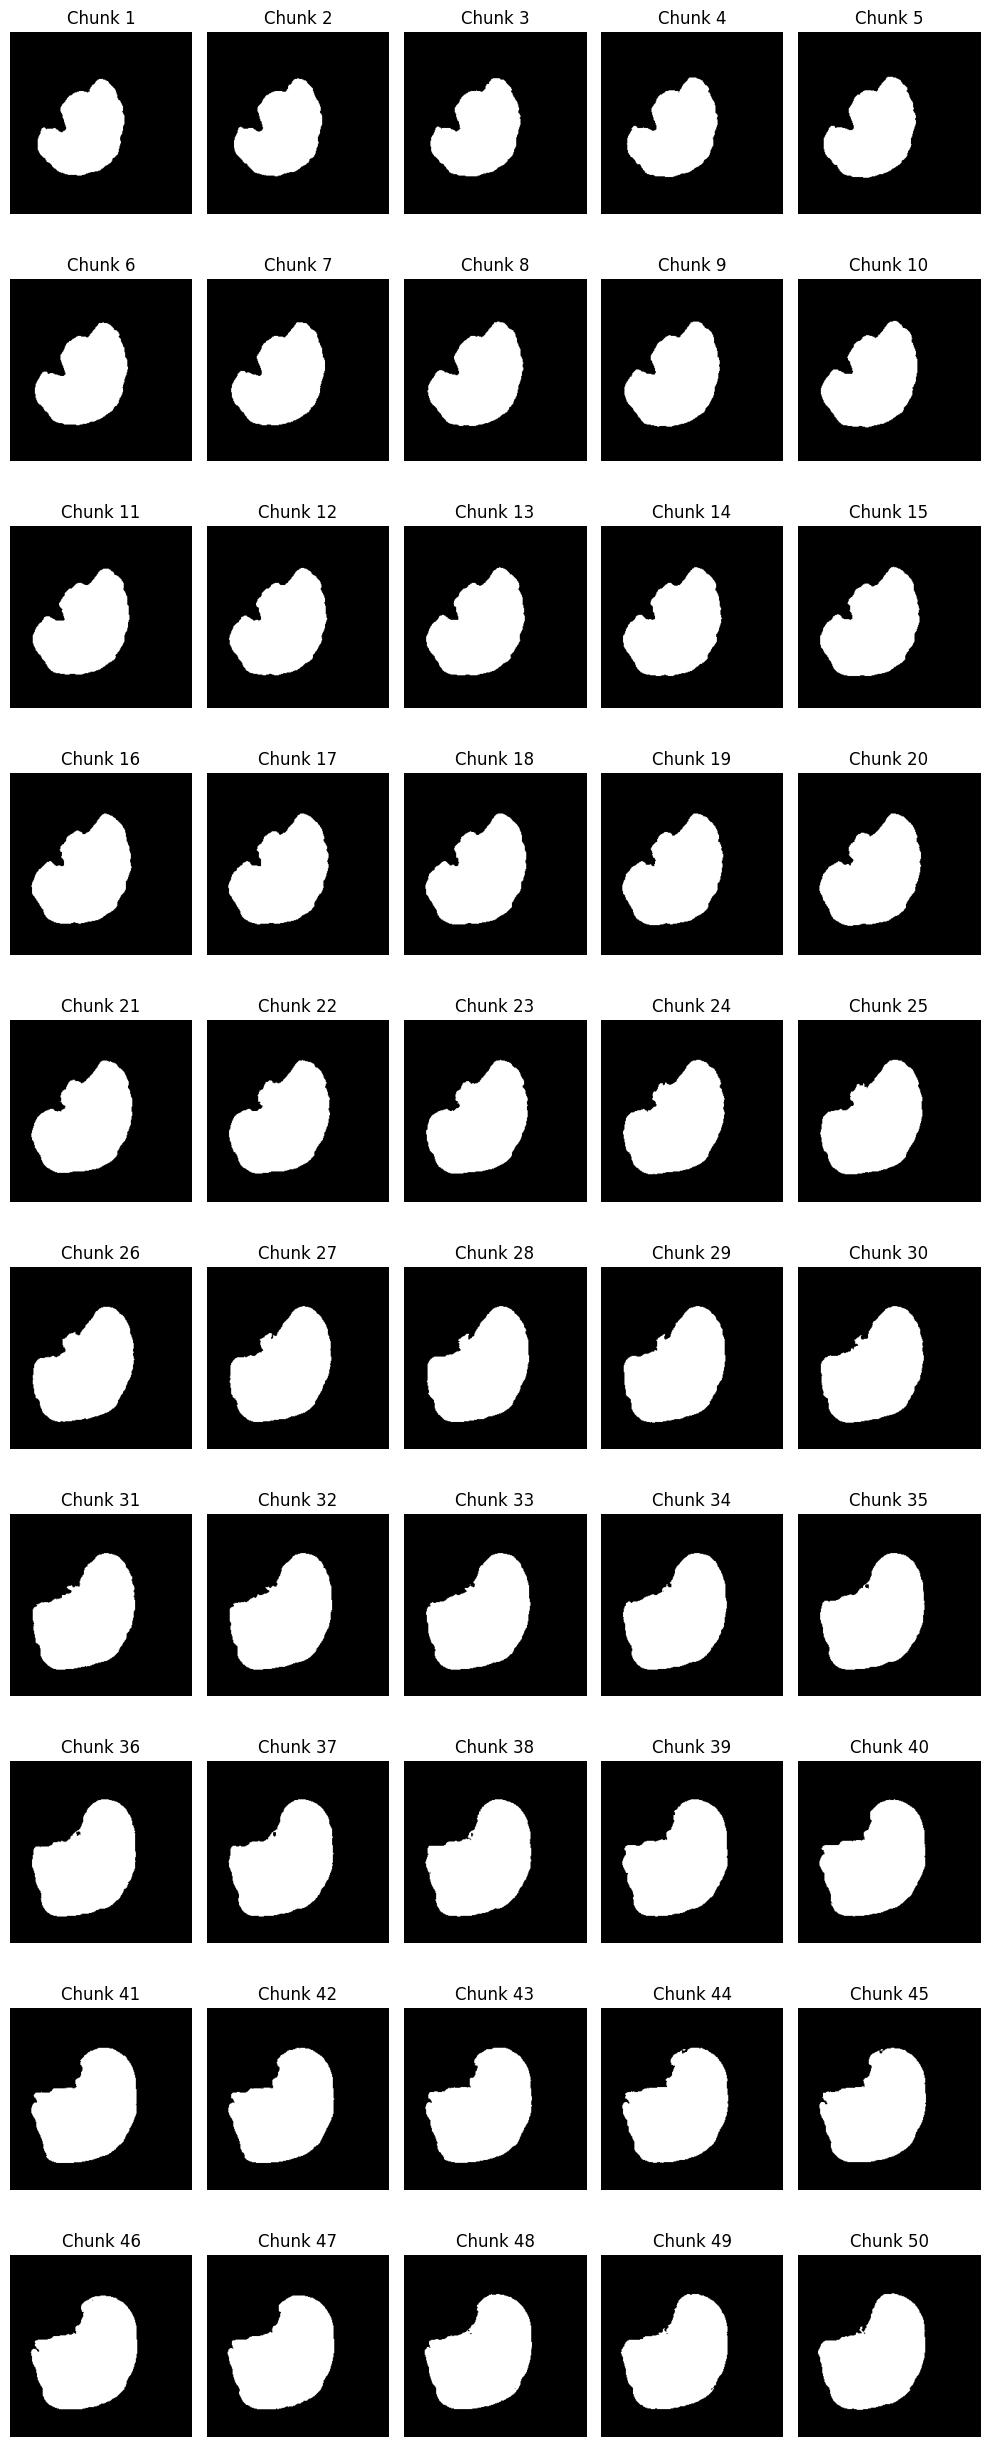

In [9]:
img =  (ds_train[420]['mask'])
image_array = np.squeeze(img.numpy())
num_chunks = 50
num_slices_per_chunk = image_array.shape[-1] // num_chunks

plt.figure(figsize=(10, 25))
for i in range(num_chunks):
    start_slice = i * num_slices_per_chunk
    end_slice = (i + 1) * num_slices_per_chunk
    plt.subplot(10, 5, i + 1) 
    plt.imshow(image_array[:, :, i+50], cmap='gray') 
    plt.title(f"Chunk {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Definition:

In [3]:

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv3d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_c)

        self.conv2 = nn.Conv3d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool3d((2, 2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose3d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """Encoder block"""
        self.e1 = encoder_block(1, 16)
        self.e2 = encoder_block(16, 32)
        self.e3 = encoder_block(32, 64)
        self.e4 = encoder_block(64, 128)

        self.b = conv_block(128,256)
        """Decoder block"""
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        self.d4 = decoder_block(32, 16)

        self.outputs = nn.Conv3d(16, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        seg_output = self.outputs(d4)
        seg_output = torch.sigmoid(seg_output)

        return seg_output


## Training loop:

In [4]:
def train(train_loader, val_loader, model, optimizer, scheduler, max_epochs, root_dir):

    metrices = {}
    loss_object = DiceLoss(to_onehot_y = True)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print('Device set to Cuda')
    else:
        device = torch.device('cpu')
    model.train()
    best_val_loss = 0.0
    best_mae_score = 0.0
    for epoch in range(1,max_epochs +1):
        train_loss = 0.0
        val_loss = 0.0
    
        print("Epoch ", epoch)
        print("Train:", end ="")

        for step, batch in enumerate(train_loader):
            img, mask = (batch["img"].cuda(), batch["mask"].cuda())
       
            optimizer.zero_grad()

            pred_mask = model(img)

            loss = loss_object(pred_mask, mask)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            print("=", end = "")

        train_loss = train_loss/(step+1)
        metrices["train_loss"] = train_loss
        

        print()
        print("Val:", end ="")
        with torch.no_grad():
                mae_loss=0.0
                for step, batch in enumerate(val_loader):
                    img, mask = (batch["img"].cuda(), batch["mask"].cuda())

                    pred_mask = model(img)


                    loss = loss_object(pred_mask, mask)
                    val_loss += loss.item()

                    print("=", end = "")
                print()
                val_loss = val_loss/(step+1)
                metrices["val_loss"] = val_loss


        print("Training epoch ", epoch, ", train loss:", train_loss, ", val loss:", val_loss, " | ", optimizer.param_groups[0]['lr'])
        #wandb.log(metrices)
        if epoch == 1:
            best_val_loss = val_loss
        if val_loss < best_val_loss:
            print("Saving model")
            best_val_loss = val_loss
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }

            torch.save(state, 'path to folder where you want to save model' + f"model_{epoch}.pth")
        scheduler.step()
    return

In [ ]:

if __name__ == "__main__":

    learning_rate = 0.001
    batch_size = 2
    epochs = 10
    root_dir = 'path/to/dataset/' # replace it with the path of your dataset folder
    


    ds_train, train_loader, ds_val, val_loader = load_data( batch_size, root_dir)
    

    model = build_unet()
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print('device set to Cuda')

    else:
        print ("Cuda not found")
        device= torch.device('cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.6)

    
    print("Start of training...")
    train(train_loader, val_loader, model, optimizer, scheduler, epochs, root_dir)
    print("End of training...")

# Inference:

In [14]:
def display_examples(original_images,masks,segmented_output,patch_number):
    original_image = np.array(original_images)
    masks = np.array(masks)
    segmented_output = np.array(segmented_output)

    chunk_size = patch_number
    
    for i in range(len(original_image)): #iterate over complete list
        for j in range(len(original_image[0])): # iterate over batch
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
        
            # Display original image
            axes[0].imshow(np.squeeze(original_image[i, j, :, :, chunk_size]), cmap='gray')
            axes[0].axis('off')
            axes[0].set_title('Original Image')
        
            # Display mask
            axes[1].imshow(np.squeeze(masks[i, j, :, :, chunk_size]), cmap='gray')
            axes[1].axis('off')
            axes[1].set_title('Mask')
        
            # Display segmented output
            axes[2].imshow(np.squeeze(segmented_output[i, j, :, :, chunk_size]), cmap='gray')
            axes[2].axis('off')
            axes[2].set_title('Segmented Output')
        
            plt.tight_layout()
            plt.show()

In [5]:
# load the best saved model
state = torch.load('/home/wamika/ml_project/models/segmentation/model_5.pth')
model = build_unet()
model.load_state_dict(state['state_dict'])
device = torch.device("cuda")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer.load_state_dict(state['optimizer'])

In [52]:
import nibabel as nib
root_dir = '/home/wamika/ml_project/anat/'
save_results = '/home/wamika/ml_project/results/segmentation/'
ds_train, train_loader, ds_val, val_loader, ds_test, test_loader = load_data( 2, root_dir)
i =0
segmented_output = []
masks = []
original_image = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        results_dir = os.path.join(save_results,str(i+1))
        os.makedirs(results_dir)
        img, mask = (batch["img"].cuda(), batch["mask"])
        masks.append(mask)
        pred_mask = model(img)
        original_image.append(img.cpu())
        segmented_output.append(pred_mask.cpu())
        nib.save(nib.Nifti1Image((img[0].cpu().numpy()*255).astype(np.uint8).squeeze(0),affine=np.eye(4)), os.path.join(results_dir,'img1.nii.gz'))
        nib.save(nib.Nifti1Image((img[1].cpu().numpy()*255).astype(np.uint8).squeeze(0),affine=np.eye(4)), os.path.join(results_dir,'img2.nii.gz'))
        nib.save(nib.Nifti1Image((mask[0].cpu().numpy()*255).astype(np.uint8).squeeze(0),affine=np.eye(4)), os.path.join(results_dir,'mask1.nii.gz'))
        nib.save(nib.Nifti1Image((mask[1].cpu().numpy()*255).astype(np.uint8).squeeze(0),affine=np.eye(4)), os.path.join(results_dir,'mask2.nii.gz'))
        nib.save(nib.Nifti1Image((pred_mask[0].cpu().numpy()*255).astype(np.uint8).squeeze(0),affine=np.eye(4)), os.path.join(results_dir,'output1.nii.gz'))
        nib.save(nib.Nifti1Image((pred_mask[1].cpu().numpy()*255).astype(np.uint8).squeeze(0),affine=np.eye(4)), os.path.join(results_dir,'output2.nii.gz'))
        i = i+1
        if i==10:
            break

Total images: 653
train set 489 489
val set 98 98
test set 66 66


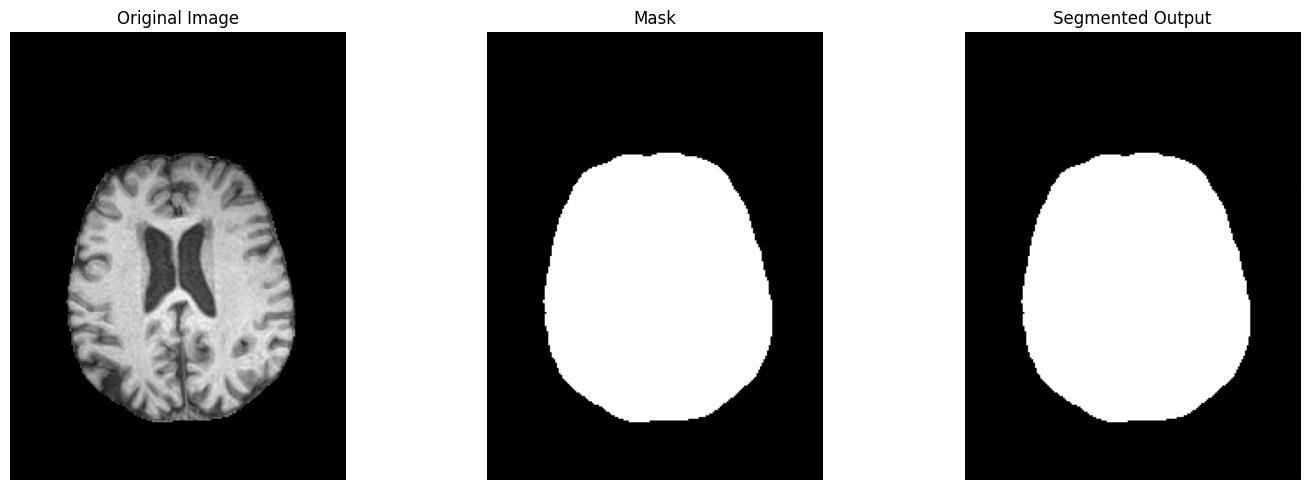

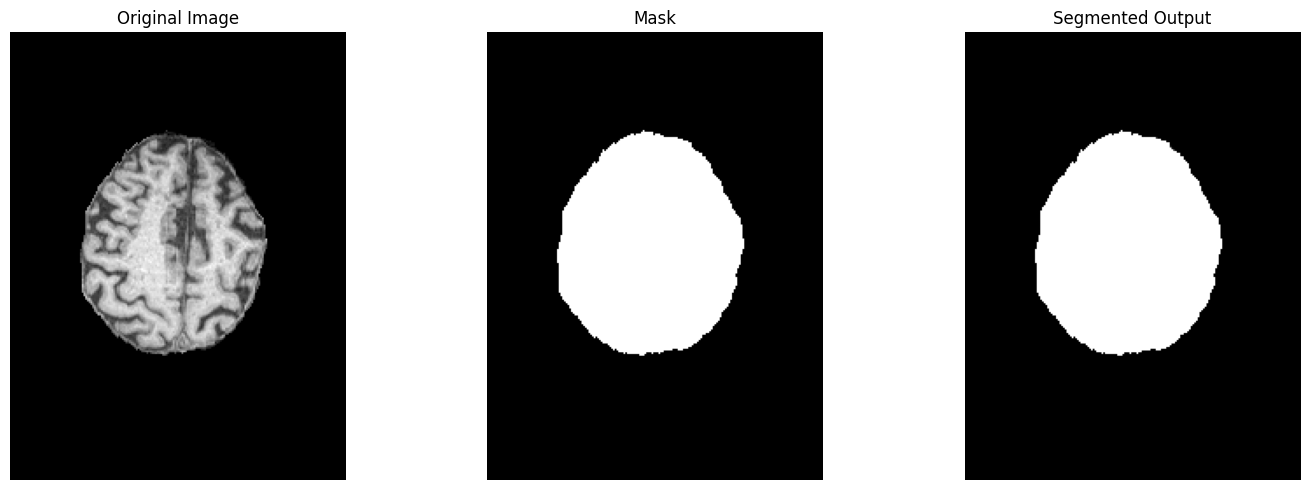

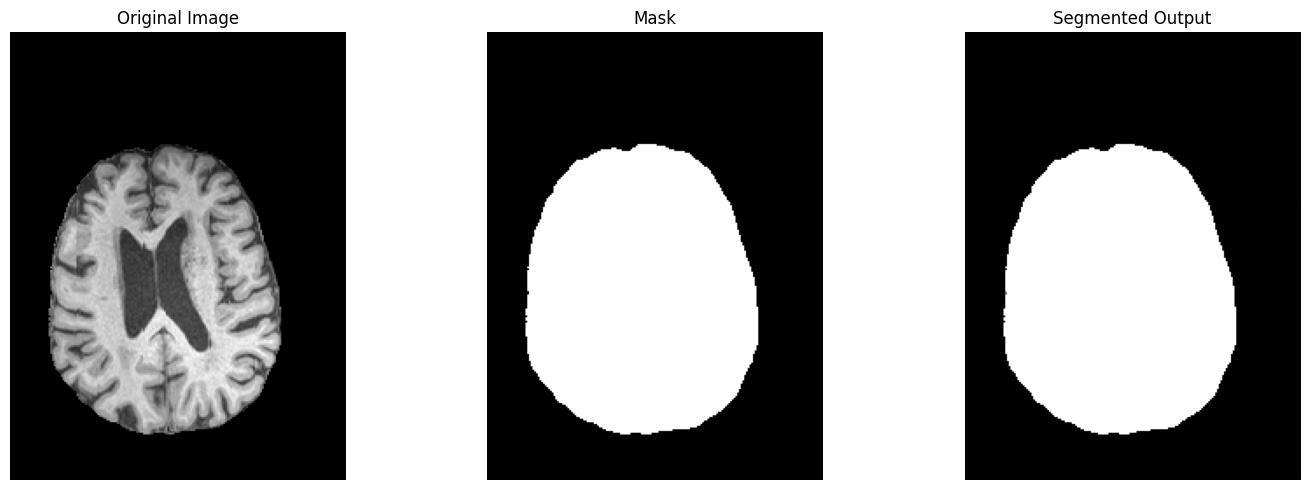

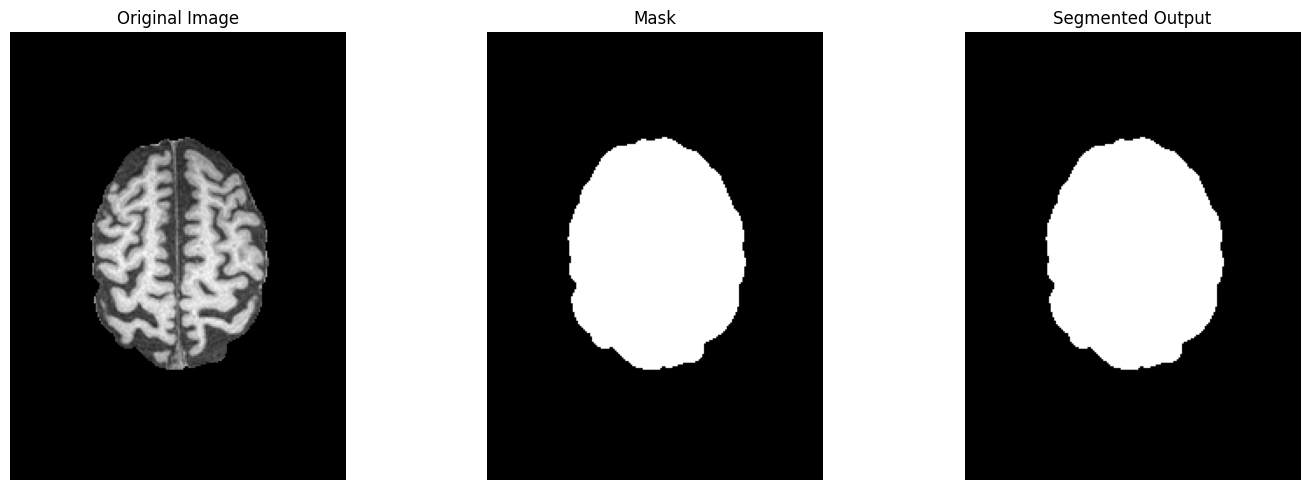

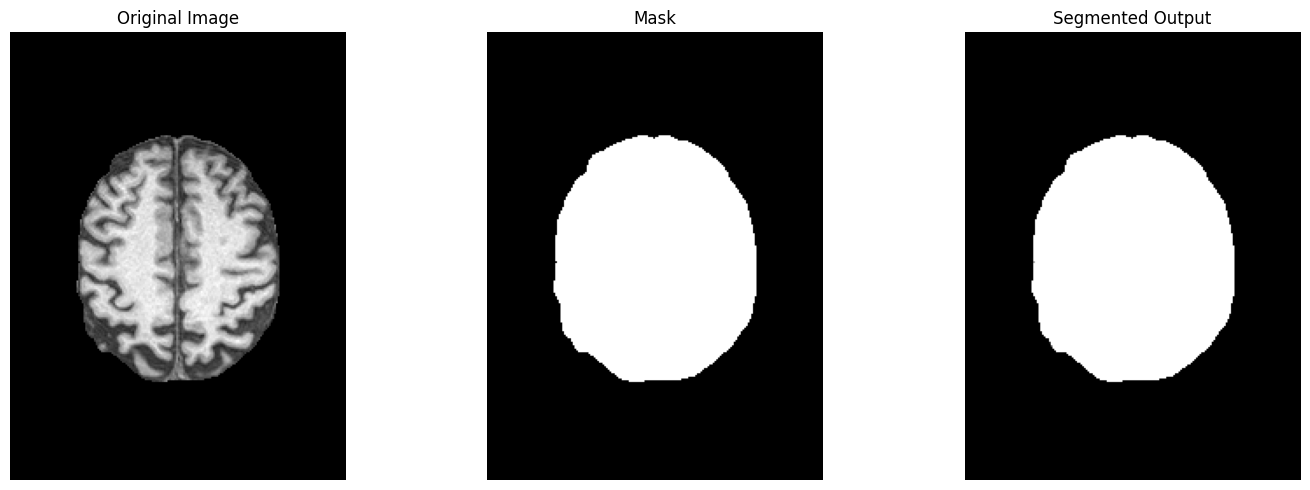

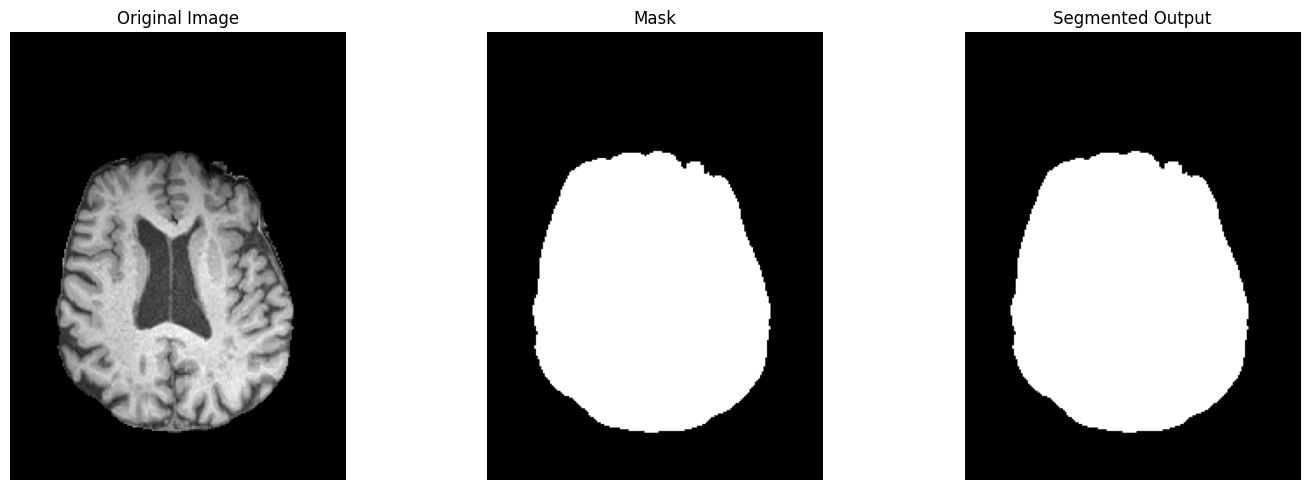

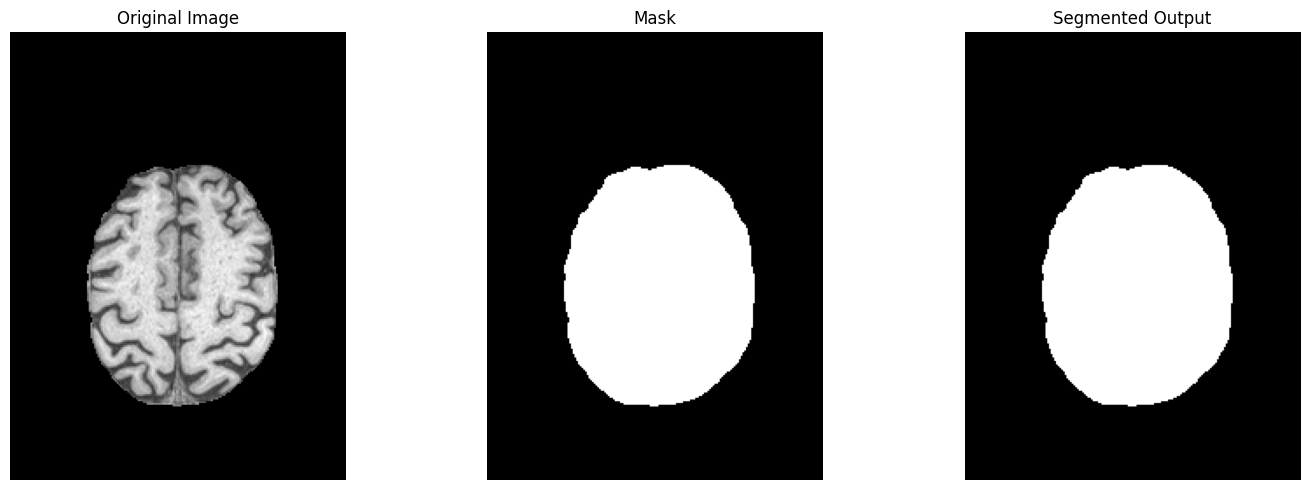

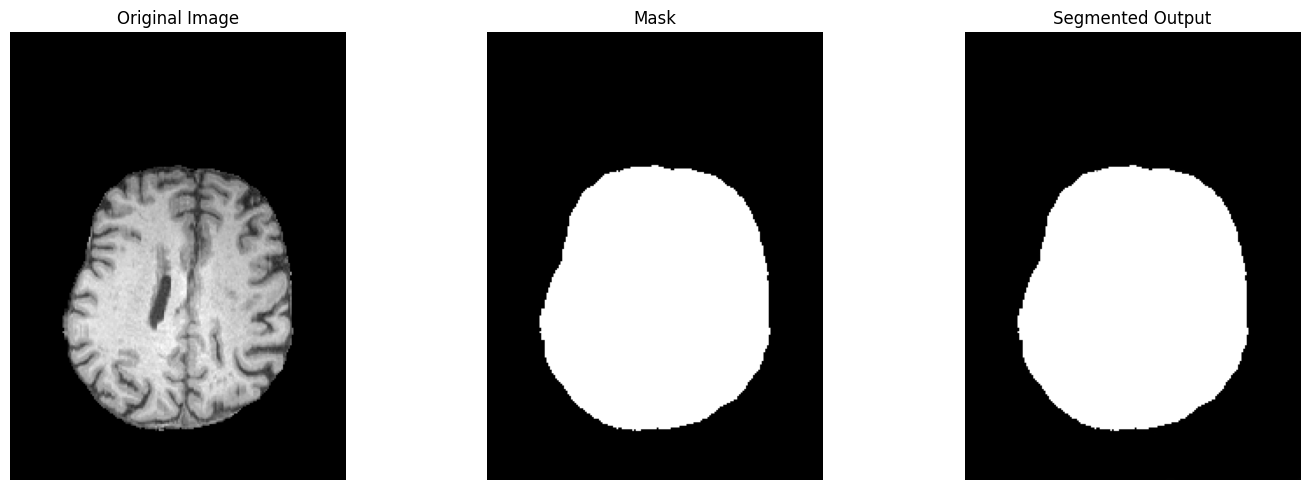

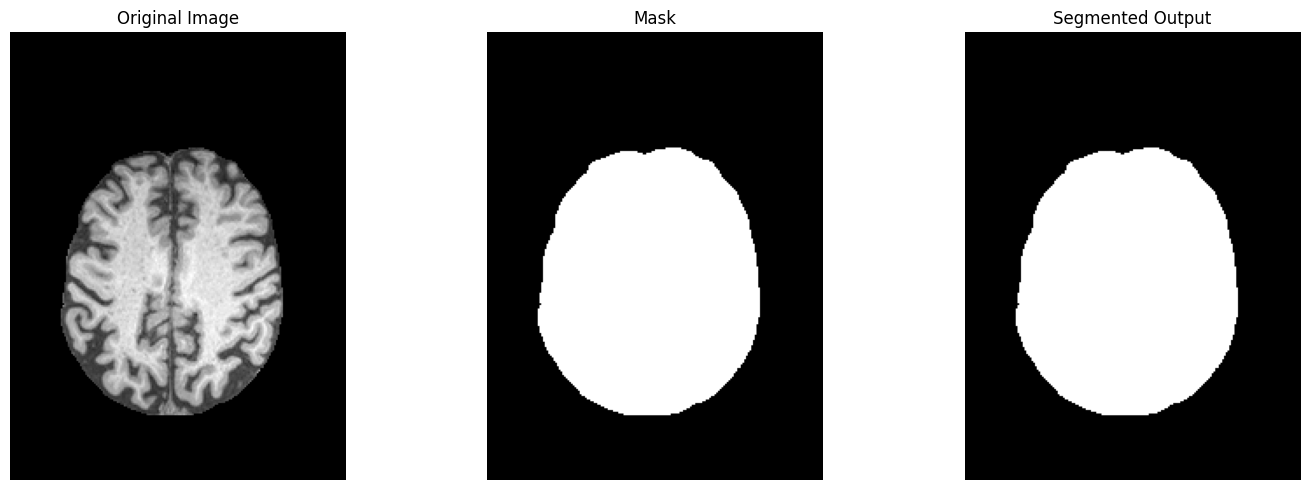

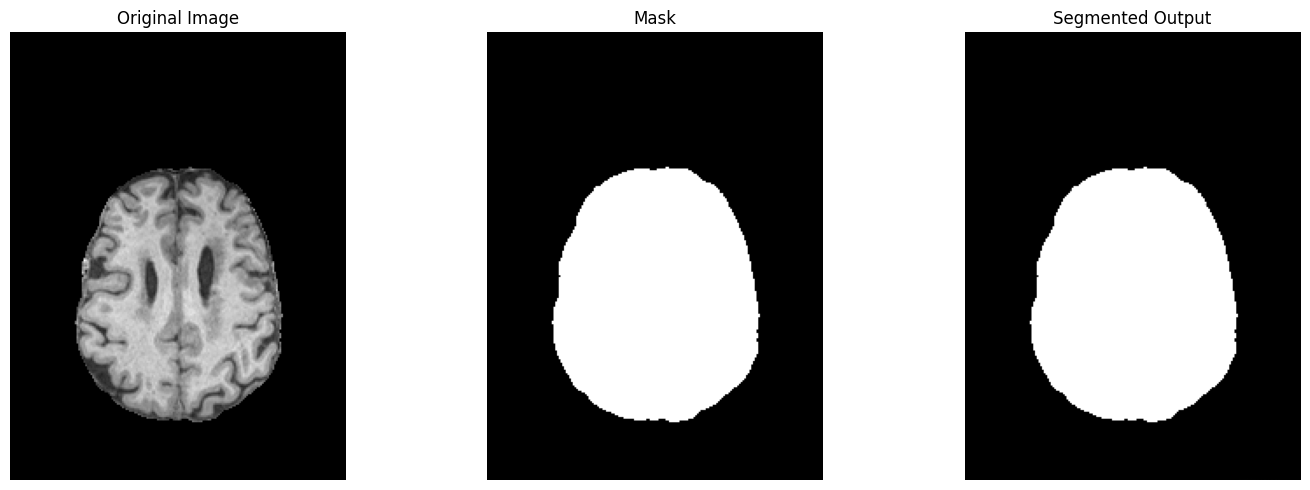

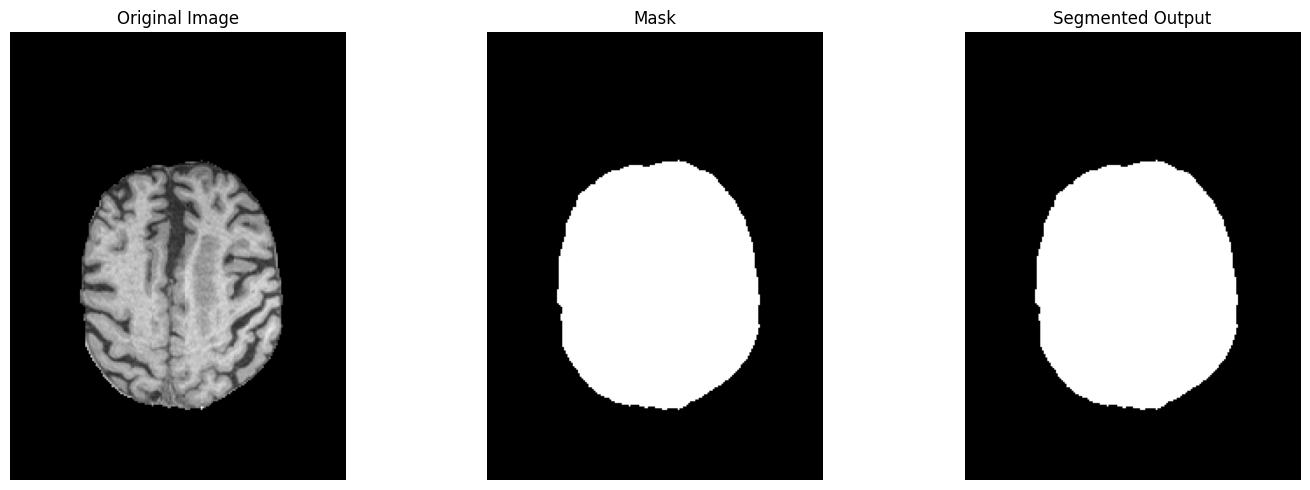

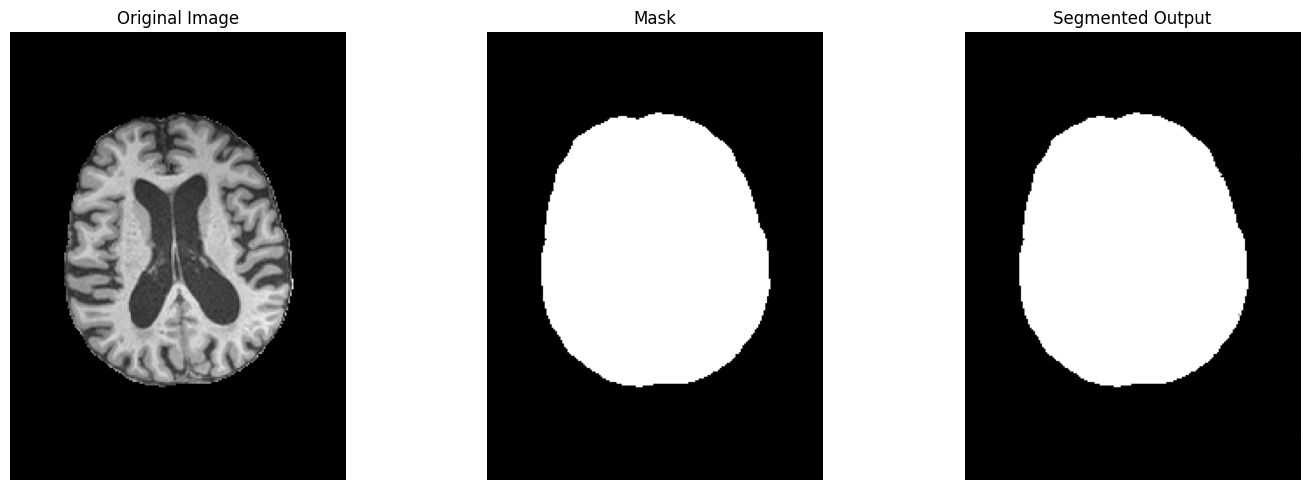

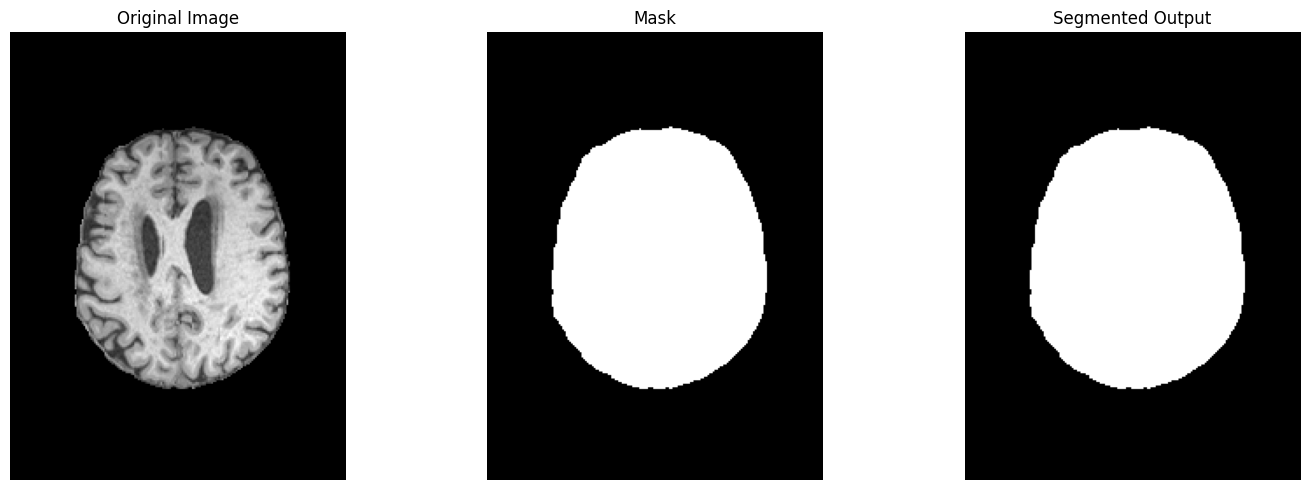

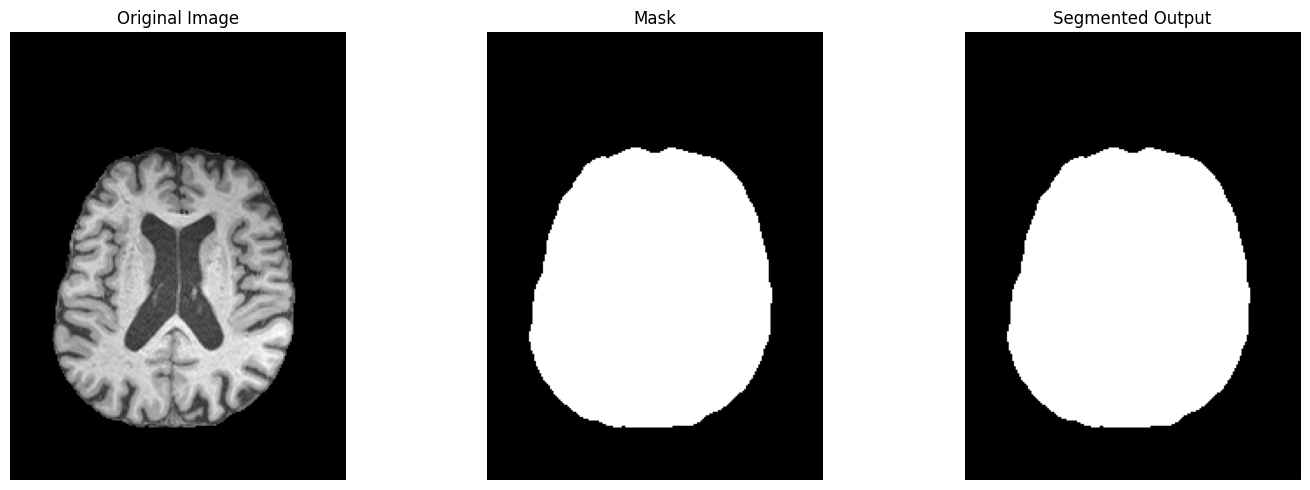

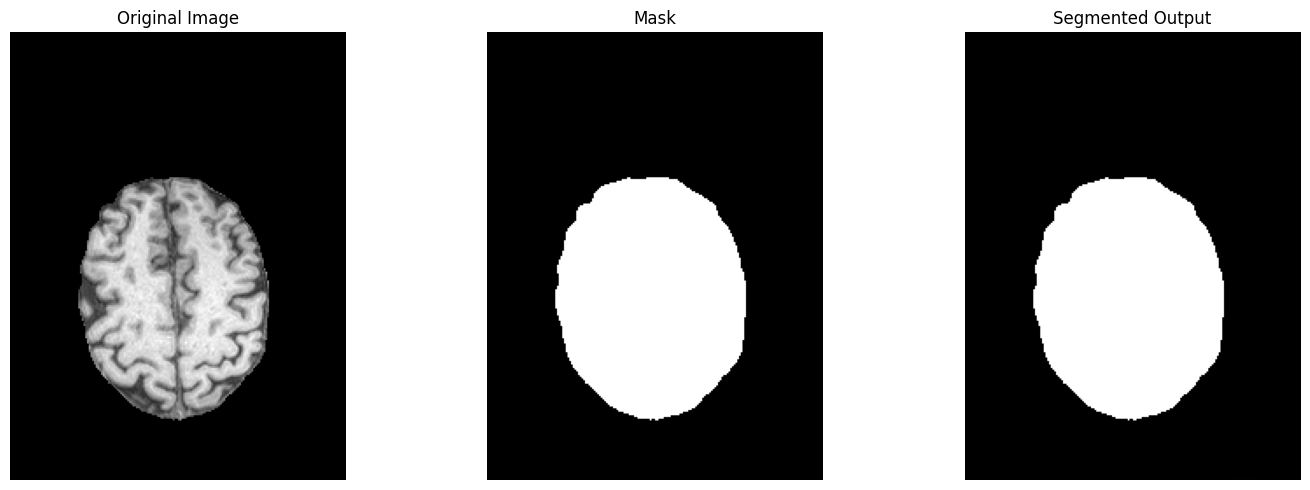

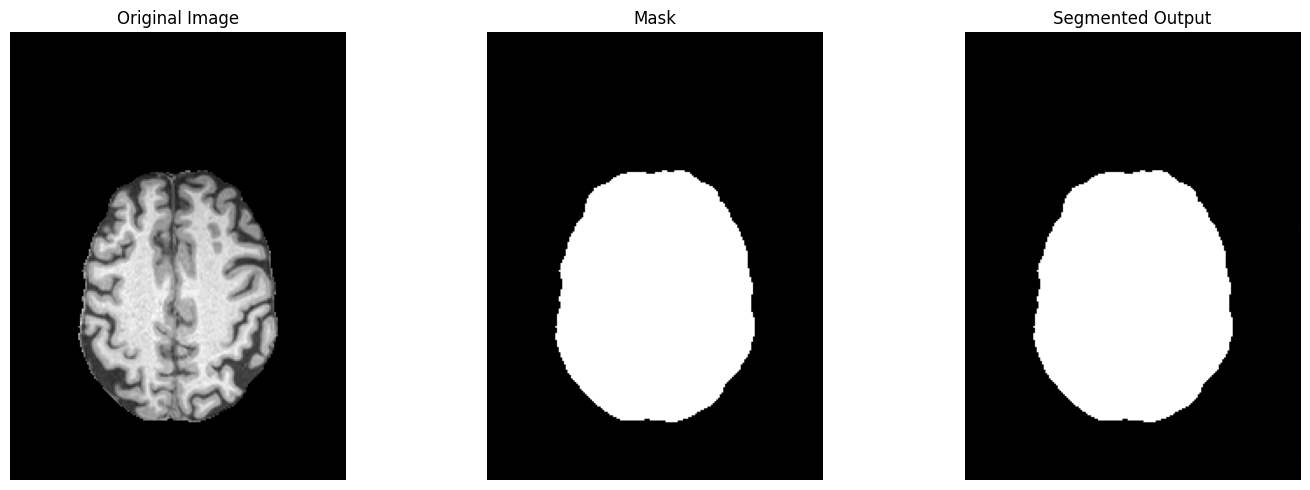

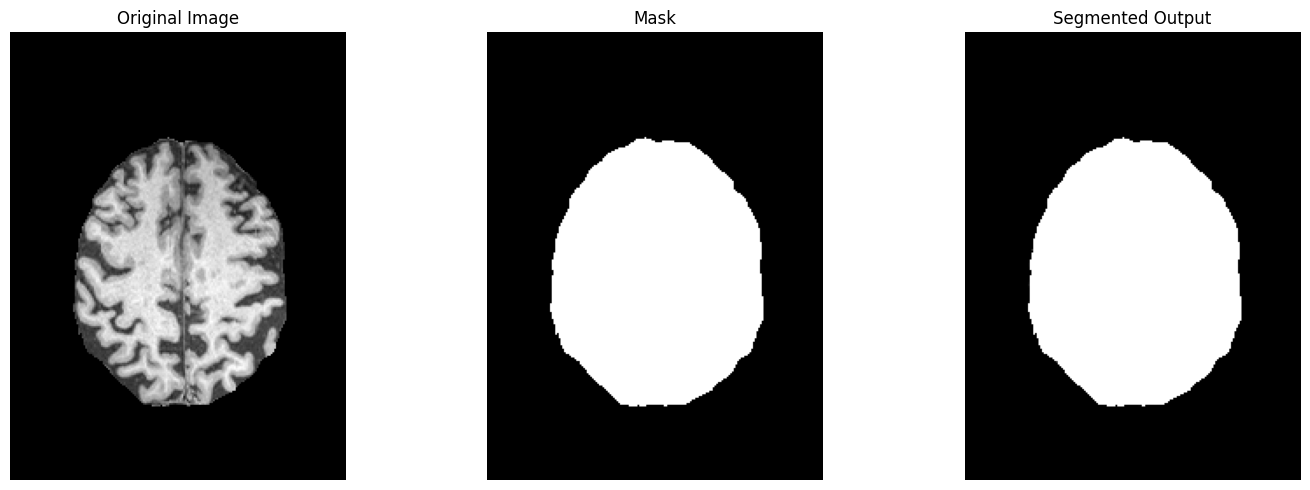

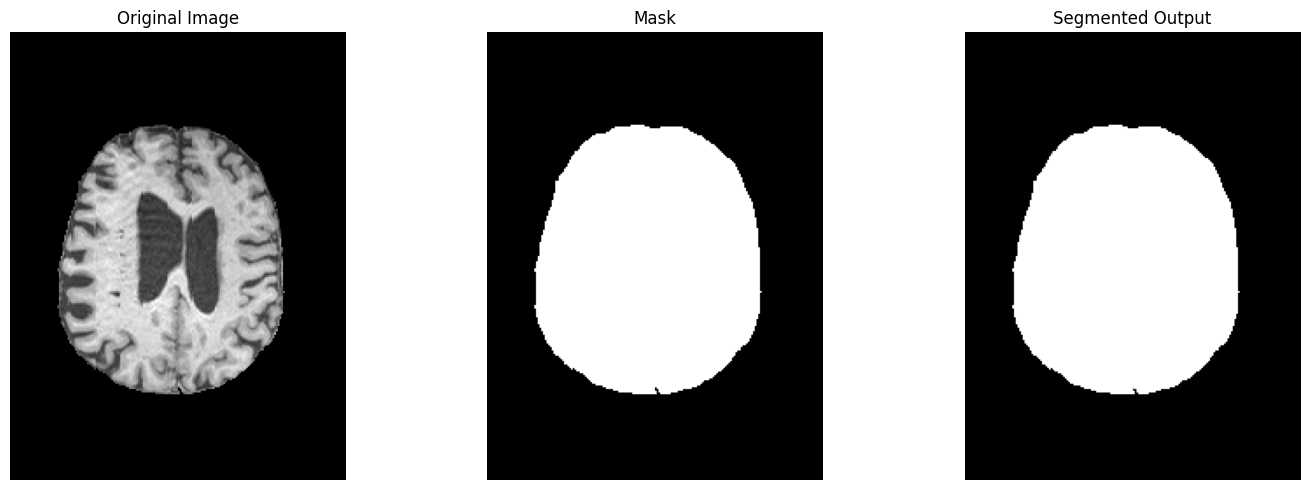

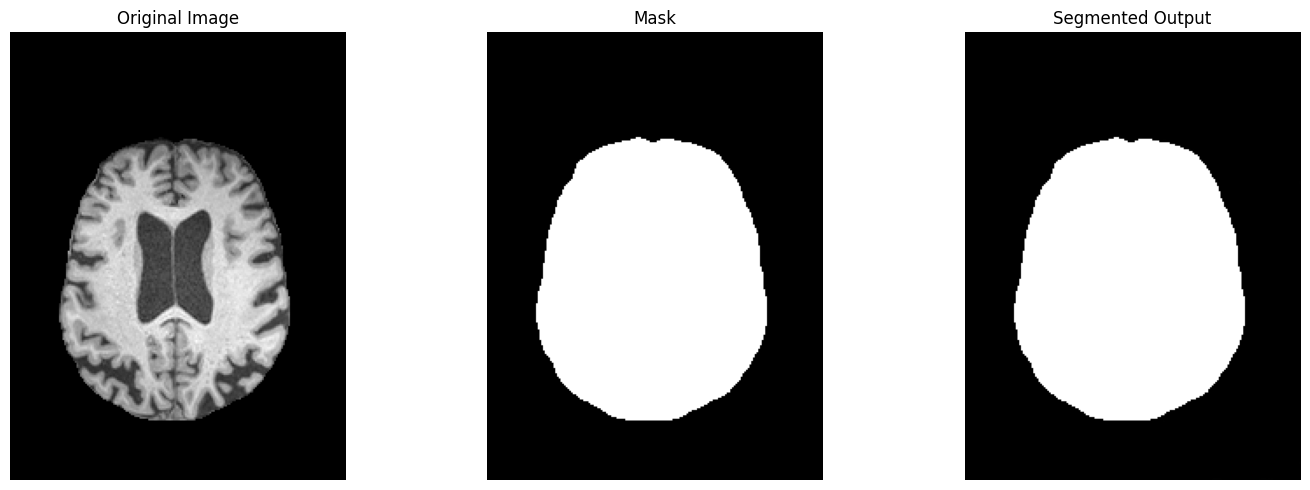

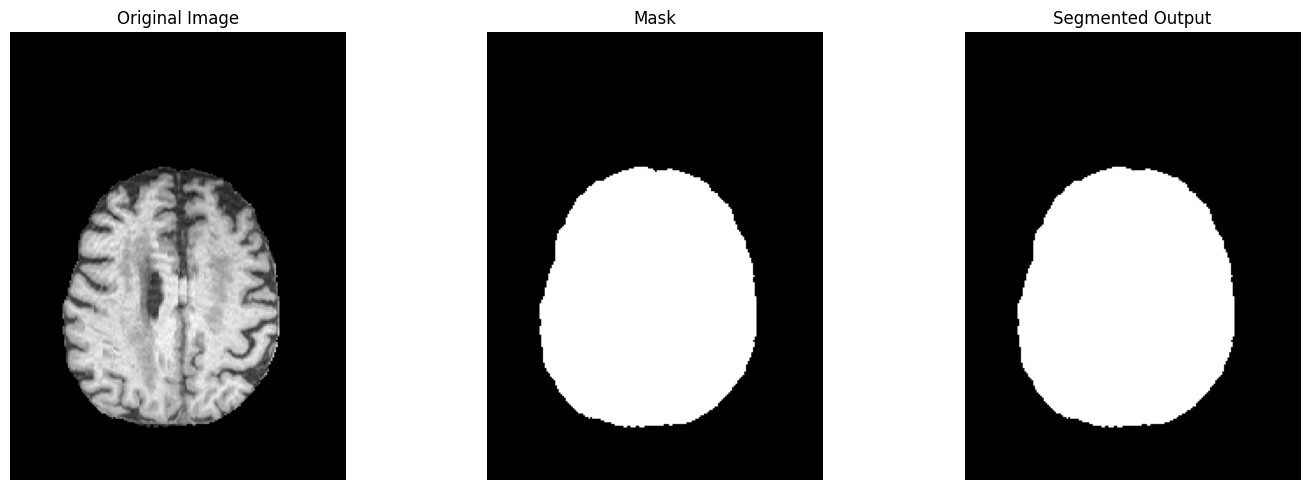

In [29]:
display_examples(original_image,masks,segmented_output,150)